# Analiz

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("sales.csv")
df

,order_id,date,item_name,item_type,item_price,quantity,transaction_amount,transaction_type,received_by,time_of_sale
0,1,07-03-2022,Aalopuri,Fastfood,20,13,260,NaN,Mr.,Night
1,2,8/23/2022,Vadapav,Fastfood,20,15,300,Cash,Mr.,Afternoon
2,3,11/20/2022,Vadapav,Fastfood,20,1,20,Cash,Mr.,Afternoon
3,4,02-03-2023,Sugarcane juice,Beverages,25,6,150,Online,Mr.,Night
4,5,10-02-2022,Sugarcane juice,Beverages,25,8,200,Online,Mr.,Evening
...,...,...,...,...,...,...,...,...,...,...
995,996,3/19/2023,Frankie,Fastfood,50,10,500,NaN,Mrs.,Evening
996,997,9/20/2022,Sandwich,Fastfood,60,7,420,NaN,Mr.,Evening
997,998,1/26/2023,Sandwich,Fastfood,60,13,780,NaN,Mr.,Evening
998,999,8/27/2022,Panipuri,Fastfood,20,5,100,NaN,Mrs.,Afternoon


Veri kümesi 1000 satır ve 10 sütun içermektedir. 
Veri kümesinin her satırı bir siparişe ilişkin bilgileri içerir.

Amacımız, veri kümemizde bulunan bilgileri kullanarak "quantity" (miktar) sütunundaki değerleri tahmin etmektir. Bu tahminleme süreci, sipariş tarihi, ürün adı, ürün tipi, fiyatı, işlem tipi gibi diğer sütunlardaki verilerin analizine dayanacaktır.

Her sütun için veri türünü kontrol edelim:

In [2]:
df.dtypes

order_id               int64
date                  object
item_name             object
item_type             object
item_price             int64
quantity               int64
transaction_amount     int64
transaction_type      object
received_by           object
time_of_sale          object
dtype: object

In [3]:
df.describe()

,order_id,item_price,quantity,transaction_amount
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,33.315000,8.162000,275.230000
std,288.819436,14.921744,4.413075,204.402979
min,1.000000,20.000000,1.000000,20.000000
25%,250.750000,20.000000,4.000000,120.000000
50%,500.500000,25.000000,8.000000,240.000000
75%,750.250000,50.000000,12.000000,360.000000
max,1000.000000,60.000000,15.000000,900.000000


Satışlarımızı vakit'e göre inceleyelim;

In [4]:
import plotly.express as px

fig = px.histogram(df, x="item_name", y="quantity", marginal="box", title="Yemek Satışları (Vakit)", color="time_of_sale")
fig.update_layout(bargap=0.1)
fig.show()

Yiyecek ve içecek satışlarını vakit'e göre incelediğimizde satışlar birbirine çok yakındır.

In [5]:
pd.pivot_table(df, columns='time_of_sale', index='item_name', values='quantity', aggfunc='sum')

time_of_sale,Afternoon,Evening,Midnight,Morning,Night
item_name,,,,,
Aalopuri,226,136,223,215,244
Cold coffee,337,235,203,287,299
Frankie,238,240,198,204,270
Panipuri,230,241,278,233,244
Sandwich,164,206,201,234,292
Sugarcane juice,325,283,237,206,227
Vadapav,194,199,235,195,183


# Ön İşleme

In [6]:
# Tarih sütunundan yıl, ay ve gün bilgilerini çıkararak yeni sütunlar ekleme
df["date"] = df["date"].str.replace("/", "-")
date = pd.to_datetime(df["date"])
df['year'] = date.dt.year
df['month'] = date.dt.month
df['day'] = date.dt.day
df["date"] = pd.to_datetime(date, format="Y-M-D")
# df = df.drop(["date"], axis=1)

Boş değer olmadığından bu adımın mağaza satış veri kümesi için gerekli olmadığını unutmayın. Ayrıca, dağılımlarına bağlı olarak farklı sütunlara farklı bir atama stratejisi uygulayabiliriz (örneğin, normal dağılım için ortalama ve üstel dağılım için medyan).

Ayrıca değerleri (0, 1) aralığına ölçeklendirelim.

In [7]:
# from sklearn import preprocessing

# categorical_columns = ['item_name', 'item_type', 'transaction_type', 'received_by', 'time_of_sale']
# # Kategorik verileri one-hot encoding ile dönüştürme
# enc = preprocessing.OneHotEncoder()
# encoded_categorical_columns = enc.fit_transform(df[categorical_columns])
# encoded_feature_names = enc.get_feature_names_out(categorical_columns)
# encoded_categorical_df = pd.DataFrame(encoded_categorical_columns.toarray(), columns=encoded_feature_names)

# df = df.drop(categorical_columns, axis=1)
# df = pd.concat([df, encoded_categorical_df], axis=1)

In [8]:
# from scipy import stats

# # Outlier'ların Z-skoru yöntemi ile belirlenmesi ve işlenmesi
# z_scores = np.abs(stats.zscore(df))
# plt.plot(z_scores)
# df = df[(z_scores < 3).all(axis=1)]
# plt.plot(df)
# len(df) - len(df)

In [9]:
# from sklearn.preprocessing import MinMaxScaler

# numeric_cols = df.select_dtypes(np.number).columns
# scaler = MinMaxScaler().fit(df[numeric_cols])
# df[numeric_cols] = scaler.transform(df[numeric_cols])

In [10]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(24, 12))
# sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
# plt.show()

In [11]:
# Hedef değişken ve açıklayıcı değişkenlerin ayrılması
# X = df.drop(['quantity', 'transaction_amount', 'order_id'], axis=1)
# y = df['quantity']

In [12]:
df

,order_id,date,item_name,item_type,item_price,quantity,transaction_amount,transaction_type,received_by,time_of_sale,year,month,day
0,1,2022-07-03,Aalopuri,Fastfood,20,13,260,NaN,Mr.,Night,2022,7,3
1,2,2022-08-23,Vadapav,Fastfood,20,15,300,Cash,Mr.,Afternoon,2022,8,23
2,3,2022-11-20,Vadapav,Fastfood,20,1,20,Cash,Mr.,Afternoon,2022,11,20
3,4,2023-02-03,Sugarcane juice,Beverages,25,6,150,Online,Mr.,Night,2023,2,3
4,5,2022-10-02,Sugarcane juice,Beverages,25,8,200,Online,Mr.,Evening,2022,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,2023-03-19,Frankie,Fastfood,50,10,500,NaN,Mrs.,Evening,2023,3,19
996,997,2022-09-20,Sandwich,Fastfood,60,7,420,NaN,Mr.,Evening,2022,9,20
997,998,2023-01-26,Sandwich,Fastfood,60,13,780,NaN,Mr.,Evening,2023,1,26
998,999,2022-08-27,Panipuri,Fastfood,20,5,100,NaN,Mrs.,Afternoon,2022,8,27


In [13]:
monthly_sales = df.groupby(['date', 'year', 'item_name'])['quantity'].sum().reset_index()
monthly_sales

,date,year,item_name,quantity
0,2022-04-01,2022,Sandwich,7
1,2022-04-02,2022,Cold coffee,15
2,2022-04-02,2022,Sandwich,15
3,2022-04-03,2022,Aalopuri,10
4,2022-04-03,2022,Panipuri,11
...,...,...,...,...
819,2023-03-26,2023,Vadapav,11
820,2023-03-27,2023,Panipuri,34
821,2023-03-27,2023,Sandwich,6
822,2023-03-29,2023,Cold coffee,27


In [14]:
# from sklearn import preprocessing

# categorical_columns = ['item_name']
# # Kategorik verileri one-hot encoding ile dönüştürme
# enc = preprocessing.OneHotEncoder()
# encoded_categorical_columns = enc.fit_transform(monthly_sales[categorical_columns])
# encoded_feature_names = enc.get_feature_names_out(categorical_columns)
# encoded_categorical_df = pd.DataFrame(encoded_categorical_columns.toarray(), columns=encoded_feature_names)

# monthly_sales = monthly_sales.drop(categorical_columns, axis=1)
# monthly_sales = pd.concat([monthly_sales, encoded_categorical_df], axis=1)
# monthly_sales
df

,order_id,date,item_name,item_type,item_price,quantity,transaction_amount,transaction_type,received_by,time_of_sale,year,month,day
0,1,2022-07-03,Aalopuri,Fastfood,20,13,260,NaN,Mr.,Night,2022,7,3
1,2,2022-08-23,Vadapav,Fastfood,20,15,300,Cash,Mr.,Afternoon,2022,8,23
2,3,2022-11-20,Vadapav,Fastfood,20,1,20,Cash,Mr.,Afternoon,2022,11,20
3,4,2023-02-03,Sugarcane juice,Beverages,25,6,150,Online,Mr.,Night,2023,2,3
4,5,2022-10-02,Sugarcane juice,Beverages,25,8,200,Online,Mr.,Evening,2022,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,2023-03-19,Frankie,Fastfood,50,10,500,NaN,Mrs.,Evening,2023,3,19
996,997,2022-09-20,Sandwich,Fastfood,60,7,420,NaN,Mr.,Evening,2022,9,20
997,998,2023-01-26,Sandwich,Fastfood,60,13,780,NaN,Mr.,Evening,2023,1,26
998,999,2022-08-27,Panipuri,Fastfood,20,5,100,NaN,Mrs.,Afternoon,2022,8,27


In [15]:
monthly_sales

,date,year,item_name,quantity
0,2022-04-01,2022,Sandwich,7
1,2022-04-02,2022,Cold coffee,15
2,2022-04-02,2022,Sandwich,15
3,2022-04-03,2022,Aalopuri,10
4,2022-04-03,2022,Panipuri,11
...,...,...,...,...
819,2023-03-26,2023,Vadapav,11
820,2023-03-27,2023,Panipuri,34
821,2023-03-27,2023,Sandwich,6
822,2023-03-29,2023,Cold coffee,27


In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sandwich = monthly_sales.query("item_name == 'Sandwich'")
train_sandwich = pd.DataFrame(sandwich[['quantity', 'date']])
train_sandwich.set_index('date', inplace=True)
train_sandwich.rename(columns={'quantity': 'Value'}, inplace=True)

# SARIMA modeli oluşturma ve tahmin yapma
# mevsimsel periodu (seasonal_period) belirlemeniz gerekecek, örneğin 12 aylık sezon
seasonal_period = 12  # Aylar için 12

model = SARIMAX(train_sandwich['Value'], order=(5, 2, 0), seasonal_order=(2, 2, 0, seasonal_period))
model_fit = model.fit()

# Tahmin yapma
train_sandwich['Forecast'] = model_fit.predict(start=train_sandwich.index[0], end=train_sandwich.index[-1], dynamic=False)
# Negatif tahminleri sıfırla (veya başka bir uygun dönüşüm uygula)
train_sandwich['Forecast'] = train_sandwich['Forecast'].clip(lower=0)

# Sonuçları görüntüleme
print(train_sandwich)


c:\Users\ismai\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\ismai\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



            Value   Forecast
date                        
2022-04-01      7   0.000000
2022-04-02     15  12.248786
2022-04-03      1  22.999113
2022-04-04     29   0.000000
2022-04-07     24  56.972471
...           ...        ...
2023-03-15     20   0.000000
2023-03-18     11  35.743187
2023-03-19     28   2.983686
2023-03-26      1  29.879166
2023-03-27      6  26.452005

[109 rows x 2 columns]


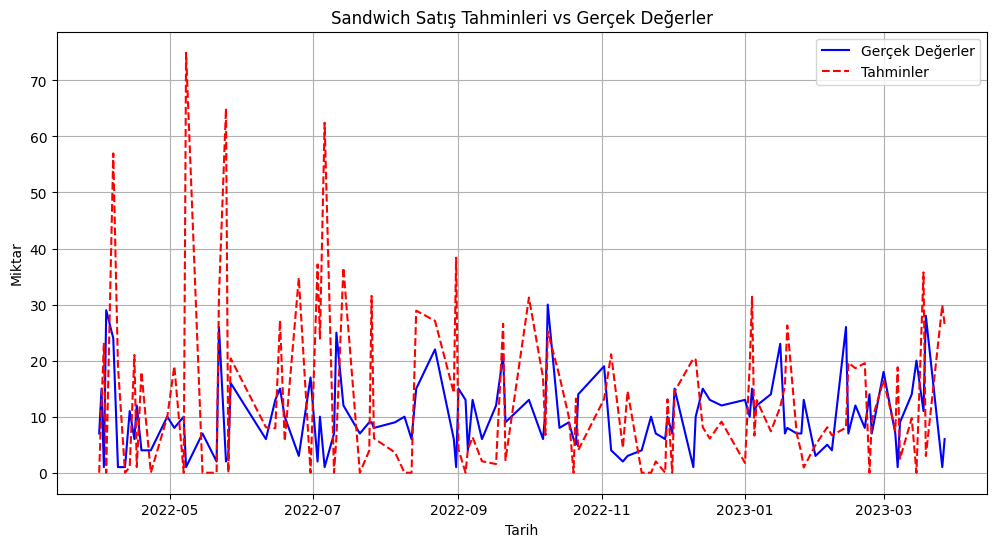

In [40]:
import matplotlib.pyplot as plt

# Gerçek değerler ve tahminler için çizim
plt.figure(figsize=(12, 6))

# Gerçek değerleri çiz
plt.plot(train_sandwich.index, train_sandwich['Value'], label='Gerçek Değerler', color='blue')

# Tahminleri çiz
plt.plot(train_sandwich.index, train_sandwich['Forecast'], label='Tahminler', color='red', linestyle='--')

# Grafik başlığı ve etiketler
plt.title('Sandwich Satış Tahminleri vs Gerçek Değerler')
plt.xlabel('Tarih')
plt.ylabel('Miktar')
plt.legend()

# Grafiği göster
plt.grid(True)
plt.show()


In [55]:
from statsmodels.tsa.arima.model import ARIMA

cold_coffee= monthly_sales.query("item_name == 'Cold coffee'")
train_cold_coffee = pd.DataFrame(cold_coffee[['quantity', 'date']])
train_cold_coffee.set_index('date', inplace=True)
train_cold_coffee.rename(columns={'quantity': 'Value'}, inplace=True)

# ARIMA modeli oluşturma ve tahmin yapma
# mevsimsel olmayan model (SARIMA yerine ARIMA)
model = ARIMA(train_cold_coffee['Value'], order=(5, 2, 0))
model_fit = model.fit()

# Tahmin yapma
train_cold_coffee['Forecast'] = model_fit.predict(start=train_cold_coffee.index[0], end=train_cold_coffee.index[-1], dynamic=False)
# Negatif tahminleri sıfırla (veya başka bir uygun dönüşüm uygula)
train_cold_coffee['Forecast'] = train_cold_coffee['Forecast'].clip(lower=0)

# Sonuçları görüntüleme
print(train_cold_coffee)


            Value   Forecast
date                        
2022-04-02     15   0.000000
2022-04-04     19  22.499843
2022-04-09      6  23.000993
2022-04-19      1   2.954911
2022-04-20     16   0.000000
...           ...        ...
2023-03-22      6   3.438662
2023-03-23     10   4.956421
2023-03-24      2   8.180606
2023-03-25     13   4.560480
2023-03-29     27   8.871759

[124 rows x 2 columns]


c:\Users\ismai\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\ismai\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\ismai\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



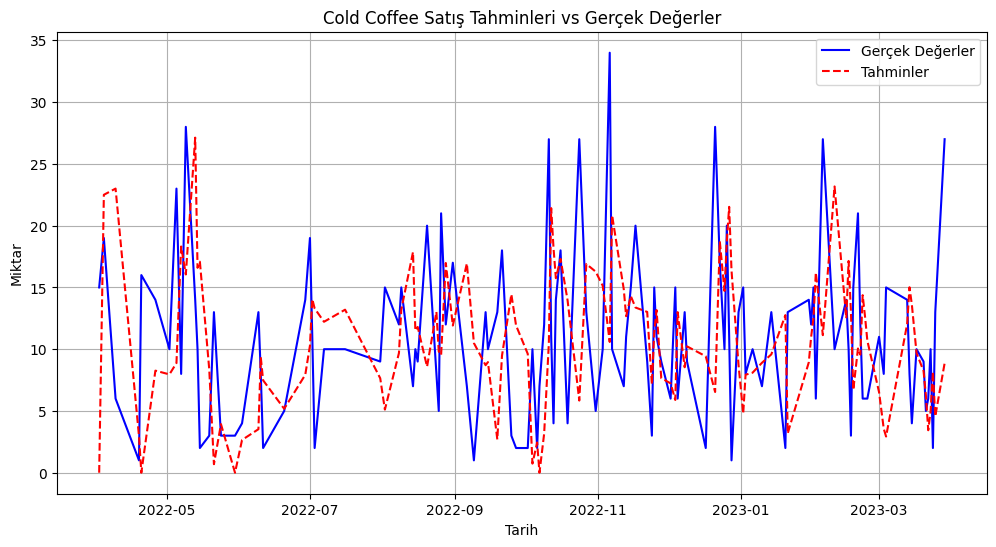

In [56]:
import matplotlib.pyplot as plt

# Gerçek değerler ve tahminler için çizim
plt.figure(figsize=(12, 6))

# Gerçek değerleri çiz
plt.plot(train_cold_coffee.index, train_cold_coffee['Value'], label='Gerçek Değerler', color='blue')

# Tahminleri çiz
plt.plot(train_cold_coffee.index, train_cold_coffee['Forecast'], label='Tahminler', color='red', linestyle='--')

# Grafik başlığı ve etiketler
plt.title('Cold Coffee Satış Tahminleri vs Gerçek Değerler')
plt.xlabel('Tarih')
plt.ylabel('Miktar')
plt.legend()

# Grafiği göster
plt.grid(True)
plt.show()
